# DGM Lab 5 - Normalizing flows

In this Lab, we will build and train normalizing flows.

A normalizing flow is an invertible mapping $g$ from samples from the data distribution to a base, "normal", distribution. The likelihood of the two distributions are then linked via the change of variable formula:

$$ p(y) = p(z)|\det \frac{\partial g(y)}{\partial y}|$$

To create normalzing flows, we need to define this mapping $z = g(y)$, where $g$ is typically composed of a series of mappings $g = g_1 \circ g_2 \circ ... \circ g_n$, where each $g_i$ should be invertible and have an easy to compute (log) determinant of the Jacobian. One such mapping is an Affine Coupling Layer.

## Affine Coupling Layer

The affine coupling layer partitions the input in two partitions $I_1, I_2$. One part is kept constant, the other is transformed with an affine transformation, which has its scale and shift parameters provided by an arbitrary functions $s(.)$ and $t(.)$:

$$ z_1 = y_1 $$
$$ z_2 = y_2 \odot \exp(s(y_1)) + t(y_1) $$

For this transformation, the Jacobian becomes a lower triangualar matrix, with the log determinant equal to $\sum_i s(y_1)_i$.

### Assignment 1 - Transforming the Moon dataset

Write a `AffineCouplingLayer` class, that extends from `torch.nn.Module` and implements a basic affine coupling layer. To partition the inputs, just split the input vector in two, and use first half and second half as $y_1$ and $y_2$ (or the flipped version where the second half is kept constant and the first half is tranformed). Implement the scale and shift functions using a simple, fully connected neural network with 2 hidden layers and activations at choice. The class should have the following two methods: `forward(self, x)`, which has two outputs, i.e. the transformed sample (batch) and the log determinant of the Jacobian of the operation, and `inverse(self, z)`, which returns the result of the inverse operation.

In [ ]:
import torch
import torch.nn as nn

class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, flip=False):
        super().__init__()
        self.flip = flip
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2),
            nn.Tanh()
        )
        self.shift_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        if self.flip:
            x1, x2 = x2, x1

        s = self.scale_net(x1)
        t = self.shift_net(x1)
        z2 = x2 * torch.exp(s) + t
        log_det = s.sum(dim=1)

        if self.flip:
            z = torch.cat([z2, x1], dim=1)
        else:
            z = torch.cat([x1, z2], dim=1)
        return z, log_det

    def inverse(self, z):
        z1, z2 = torch.chunk(z, 2, dim=1)
        if self.flip:
            z1, z2 = z2, z1

        s = self.scale_net(z1)
        t = self.shift_net(z1)
        x2 = (z2 - t) * torch.exp(-s)

        if self.flip:
            x = torch.cat([x2, z1], dim=1)
        else:
            x = torch.cat([z1, x2], dim=1)
        return x

A normalizing flow typically consists of a stack of invertible transformations. To build a normalizing flow out of affine coupling layers, one typically stacks multiple affine coupling layers, which alternately transform the first and the second half of the inputs. Write a class `NormalizingFlow` which is basically a stack of affine coupling layers. Again provide a `forward(self, x)` and `inverse(self, z)` method. The `forward` method now transforms the data through all coupling layers, and the log determinant is the sum of all log determinants of the transformations done. The `inverse` method again calculates the inverse operation.

In [ ]:
class NormalizingFlow(nn.Module):
    def __init__(self, input_dim, n_layers=4, hidden_dim=128):
        super().__init__()
        self.layers = nn.ModuleList([
            AffineCouplingLayer(input_dim, hidden_dim, flip=(i % 2 == 1))
            for i in range(n_layers)
        ])

    def forward(self, x):
        log_det_total = 0
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_total += log_det
        return x, log_det_total

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

Now create a Pytorch dataset from [the moons data from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html), as done in Lab session 1. Now construct a `NormalizingFlow` model with a couple of affine coupling layers. Training the normalizing flow is basically forwarding data through the flow, and maximizing the likelihood of the samples (i.e. minimizing the negative log likelihood of the data). Use a 2-dimensional standard Normal distribution as base distribution. The (log) likelihood of the samples can be calculated via the change of variable formula, i.e. using the log probability of the generated points under the standard Normal distribution, and the log determinants of the Jacobians.

Experiment with the number of layers and number of hidden units. About 6 layers and 128 hidden units should give ok results, but try increasing / lowering these numbers to see the effect. Check your results by plotting generated samples, i.e. by generating standard Normal noise, and transform these to the data domain using the inverse of the trained normalizing flow. Also plot the intermediate transformed distributions after each coupling layer, to get insight how data is transformed by the flow.

Epoch 1, Loss: 1.6989
Epoch 2, Loss: 1.4074
Epoch 3, Loss: 1.3237
Epoch 4, Loss: 1.2745
Epoch 5, Loss: 1.2779
Epoch 6, Loss: 1.1991
Epoch 7, Loss: 1.1921
Epoch 8, Loss: 1.1832
Epoch 9, Loss: 1.1674
Epoch 10, Loss: 1.1388
Epoch 11, Loss: 1.1139
Epoch 12, Loss: 1.1320
Epoch 13, Loss: 1.1872
Epoch 14, Loss: 1.1186
Epoch 15, Loss: 1.1317
Epoch 16, Loss: 1.1273
Epoch 17, Loss: 1.1221
Epoch 18, Loss: 1.1297
Epoch 19, Loss: 1.1561
Epoch 20, Loss: 1.1036
Epoch 21, Loss: 1.0928
Epoch 22, Loss: 1.0950
Epoch 23, Loss: 1.1558
Epoch 24, Loss: 1.1350
Epoch 25, Loss: 1.1097
Epoch 26, Loss: 1.0993
Epoch 27, Loss: 1.0810
Epoch 28, Loss: 1.0916
Epoch 29, Loss: 1.1167
Epoch 30, Loss: 1.0754
Epoch 31, Loss: 1.0800
Epoch 32, Loss: 1.0976
Epoch 33, Loss: 1.0954
Epoch 34, Loss: 1.0842
Epoch 35, Loss: 1.0703
Epoch 36, Loss: 1.0863
Epoch 37, Loss: 1.0627
Epoch 38, Loss: 1.0773
Epoch 39, Loss: 1.0674
Epoch 40, Loss: 1.0693
Epoch 41, Loss: 1.0700
Epoch 42, Loss: 1.0649
Epoch 43, Loss: 1.0700
Epoch 44, Loss: 1.07

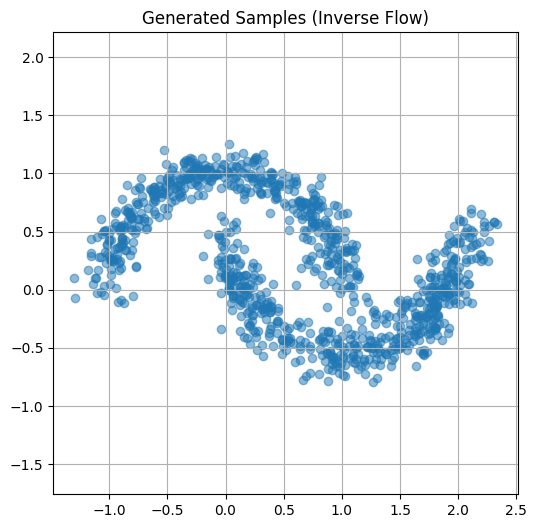

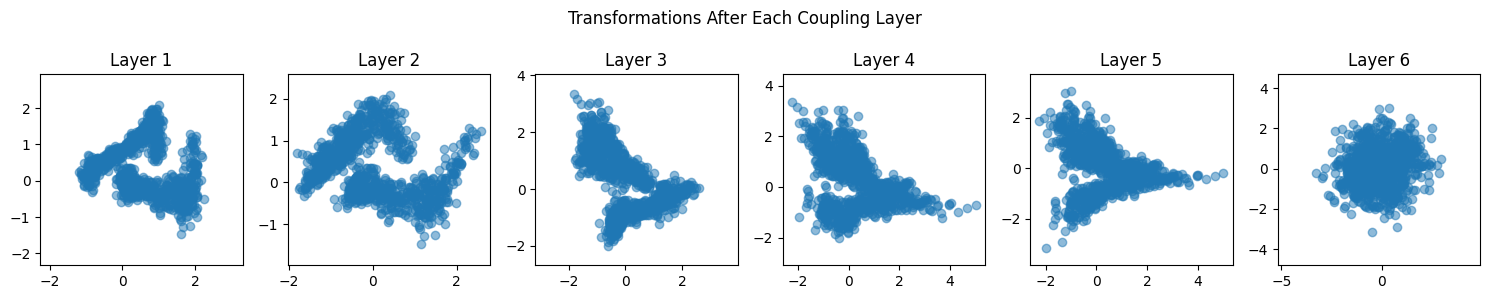

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons

# Create the dataset "moons"
X, _ = make_moons(n_samples=10000, noise=0.1)
X = torch.tensor(X, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(X), batch_size=256, shuffle=True)

# Parameters of the model and the optimizer
input_dim = 2
flow = NormalizingFlow(input_dim=input_dim, n_layers=6, hidden_dim=128)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
base_dist = torch.distributions.Normal(torch.zeros(input_dim), torch.ones(input_dim))

# Train function
def train_flow(flow, dataloader, base_dist, epochs=50):
    flow.train()
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, in dataloader:
            z, log_det = flow(x_batch)
            log_prob = base_dist.log_prob(z).sum(dim=1)
            loss = -(log_prob + log_det).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

# Visualization
@torch.no_grad()
def visualize(flow, base_dist, X, n_samples=1000):
    flow.eval()

    z_samples = base_dist.sample((n_samples,))
    x_gen = flow.inverse(z_samples)
    plt.figure(figsize=(6,6))
    plt.scatter(x_gen[:,0], x_gen[:,1], alpha=0.5)
    plt.title("Generated Samples (Inverse Flow)")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

    # flow forward
    x = X[:n_samples]
    plt.figure(figsize=(15, 3))
    for i, layer in enumerate(flow.layers):
        x, _ = layer(x)
        plt.subplot(1, len(flow.layers), i+1)
        plt.scatter(x[:, 0], x[:, 1], alpha=0.5)
        plt.title(f"Layer {i+1}")
        plt.axis("equal")
    plt.suptitle("Transformations After Each Coupling Layer")
    plt.tight_layout()
    plt.show()

# Running train and visualization
train_flow(flow, dataloader, base_dist, epochs=50)
visualize(flow, base_dist, X)

### Assignment 2 - MNIST flow

In this second assignment, the goal is to create a normalizing flow for the MNIST dataset. Try to re-use the concepts of the previous assignment, treating the 28x28 images as a flattened 784 sized vector. You might need to tweak the flow, increasing the capacity, and let it train for much longer. (Caveat: don't expect to get similar quality samples as for example GAN or VAE, so it's not required to keep on tuning forever. Some hints on workable architectures and hyperparameters for MNIST can be found in the [NICE paper](https://arxiv.org/abs/1410.8516))


Epoch 1, Loss: -1244.7428
Epoch 2, Loss: -1651.6578
Epoch 3, Loss: -1749.0821
Epoch 4, Loss: -1804.4263
Epoch 5, Loss: -1843.3005
Epoch 6, Loss: -1868.5431
Epoch 7, Loss: -1889.5261
Epoch 8, Loss: -1904.1344
Epoch 9, Loss: -1917.3786
Epoch 10, Loss: -1928.3052


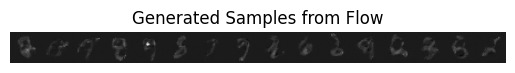

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten to 784
])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=256, shuffle=True)

# Flow config
input_dim = 784
flow = NormalizingFlow(input_dim=input_dim, n_layers=8, hidden_dim=1024)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
base_dist = torch.distributions.Normal(torch.zeros(input_dim), torch.ones(input_dim))

# Training loop
def train_flow(flow, dataloader, base_dist, epochs=10):
    flow.train()
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, _ in dataloader:
            z, log_det = flow(x_batch)
            log_prob = base_dist.log_prob(z).sum(dim=1)
            loss = -(log_prob + log_det).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

# Sample from flow
@torch.no_grad()
def generate_samples(flow, base_dist, n_samples=16):
    flow.eval()
    z = base_dist.sample((n_samples,))
    x_gen = flow.inverse(z).view(-1, 1, 28, 28)
    grid = torch.cat([x for x in x_gen], dim=2).squeeze()
    plt.imshow(grid, cmap='gray')
    plt.title("Generated Samples from Flow")
    plt.axis('off')
    plt.show()

# Train and generate
train_flow(flow, dataloader, base_dist, epochs=10)
generate_samples(flow, base_dist, n_samples=16)

## Closing remarks

Normalizing flows are very powerful for transforming samples from a dataset to a base distribution, and inverting the flow to "generate" data samples. However, as you noticed, the main drawback is that the "normal" distribution needs to have the same dimensionality as the data distribution, which makes it difficult to scale up to high-dimensional data such as images. For those who want to further explore, you could experiment with all the nifty features from RealNVP, i.e. using convolutional scale and translation functions, using checkerboard and channel-wise masking, and use a multi-scale. If you want even nicer image generations with normalizing flows, you'll have to delve into more complex models like GLOW.

This enhanced version of RealNVP transitions the model from a basic vector-based architecture to a fully image-aware flow. With convolutional coupling layers, alternating masks, and a multi-scale design, this version is well-suited for training on image datasets and generating high-quality samples.

---



In this section we further our experiments implementing RealNVP and GLOW. At first we will present RealNVP.

In [ ]:
import torch
import torch.nn as nn

class SqueezeLayer(nn.Module):
    def forward(self, x):
        B, C, H, W = x.size()
        x = x.view(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        return x.view(B, C * 4, H // 2, W // 2)

    def inverse(self, x):
        B, C, H, W = x.size()
        x = x.view(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        return x.view(B, C // 4, H * 2, W * 2)


class ConvCouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, mask_type='checkerboard'):
        super().__init__()
        self.mask_type = mask_type

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels * 2, kernel_size=3, padding=1)
        )

    def create_mask(self, x):
        B, C, H, W = x.size()
        if self.mask_type == 'checkerboard':
            pattern = torch.tensor([[(i + j) % 2 for j in range(W)] for i in range(H)], dtype=torch.float32)
            mask = pattern.unsqueeze(0).unsqueeze(0).repeat(B, C, 1, 1)
        elif self.mask_type == 'channel':
            mask = torch.zeros_like(x)
            mask[:, :C // 2] = 1
        else:
            raise ValueError("Unknown mask type.")
        return mask.to(x.device)

    def forward(self, x):
        mask = self.create_mask(x)
        x_masked = x * mask
        s, t = self.net(x_masked).chunk(2, dim=1)
        s = torch.tanh(s)
        z = (1 - mask) * (x * torch.exp(s) + t) + x_masked
        log_det = ((1 - mask) * s).view(x.size(0), -1).sum(dim=1)
        return z, log_det

    def inverse(self, z):
        mask = self.create_mask(z)
        z_masked = z * mask
        s, t = self.net(z_masked).chunk(2, dim=1)
        s = torch.tanh(s)
        x = (1 - mask) * ((z - t) * torch.exp(-s)) + z_masked
        return x


class RealNVPBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        mask_types = ['checkerboard', 'channel']
        for i in range(n_layers):
            self.layers.append(
                ConvCouplingLayer(in_channels, hidden_channels, mask_type=mask_types[i % 2])
            )

    def forward(self, x):
        log_det_total = 0
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_total += log_det
        return x, log_det_total

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z


class MultiScaleRealNVP(nn.Module):
    def __init__(self, levels=2, in_channels=1, hidden_channels=64, blocks_per_level=4):
        super().__init__()
        self.squeezes = nn.ModuleList()
        self.flows = nn.ModuleList()
        self.factor_outs = []

        C = in_channels
        for _ in range(levels):
            self.squeezes.append(SqueezeLayer())
            C *= 4
            self.flows.append(RealNVPBlock(C, hidden_channels, blocks_per_level))
            self.factor_outs.append(C // 2)
            C = C // 2  # remaining channels continue to next level

    def forward(self, x):
        log_det_total = 0
        zs = []
        self.saved_shapes = []

        for squeeze, flow, cut in zip(self.squeezes, self.flows, self.factor_outs):
            x = squeeze(x)
            x, log_det = flow(x)
            log_det_total += log_det

            z_factored = x[:, :cut]
            zs.append(z_factored.view(z_factored.size(0), -1))
            self.saved_shapes.append(z_factored.shape)

            x = x[:, cut:]

        zs.append(x.view(x.size(0), -1))
        self.saved_shapes.append(x.shape)

        return torch.cat(zs, dim=1), log_det_total

    def inverse(self, z):
        z_chunks = []
        start = 0

        for shape in self.saved_shapes:
            flat_size = torch.tensor(shape[1:]).prod().item()
            chunk = z[:, start:start + flat_size].view(-1, *shape[1:])
            z_chunks.append(chunk)
            start += flat_size

        x = z_chunks.pop()
        for squeeze, flow, _ in reversed(list(zip(self.squeezes, self.flows, self.factor_outs))):
            x = torch.cat([z_chunks.pop(), x], dim=1)
            x = flow.inverse(x)
            x = squeeze.inverse(x)
        return x

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(mnist, batch_size=64, shuffle=True)

# Model
flow = MultiScaleRealNVP(levels=2, in_channels=1, hidden_channels=64, blocks_per_level=4).to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
base_dist = torch.distributions.Normal(0, 1)

# Training loop
epochs = 20
for epoch in range(epochs):
    flow.train()
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        z, log_det = flow(x)
        log_pz = base_dist.log_prob(z).sum(dim=[1])  # over latent
        loss = -(log_pz + log_det).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(loader):.4f}")

Epoch 1/20 | Loss: -822.7477
Epoch 2/20 | Loss: -982.6117
Epoch 3/20 | Loss: -1032.1033
Epoch 4/20 | Loss: -1117.5238
Epoch 5/20 | Loss: -1159.3395
Epoch 6/20 | Loss: -1125.7784
Epoch 7/20 | Loss: -1131.5634
Epoch 8/20 | Loss: -1173.0414
Epoch 9/20 | Loss: -1187.5780
Epoch 10/20 | Loss: -1210.2153
Epoch 11/20 | Loss: -1109.0375
Epoch 12/20 | Loss: -1112.3879
Epoch 13/20 | Loss: -1158.0158
Epoch 14/20 | Loss: -1187.2025
Epoch 15/20 | Loss: -1148.4253
Epoch 16/20 | Loss: -1219.1816
Epoch 17/20 | Loss: -1200.4300
Epoch 18/20 | Loss: -1203.8314
Epoch 19/20 | Loss: -1204.6040
Epoch 20/20 | Loss: -1239.9460


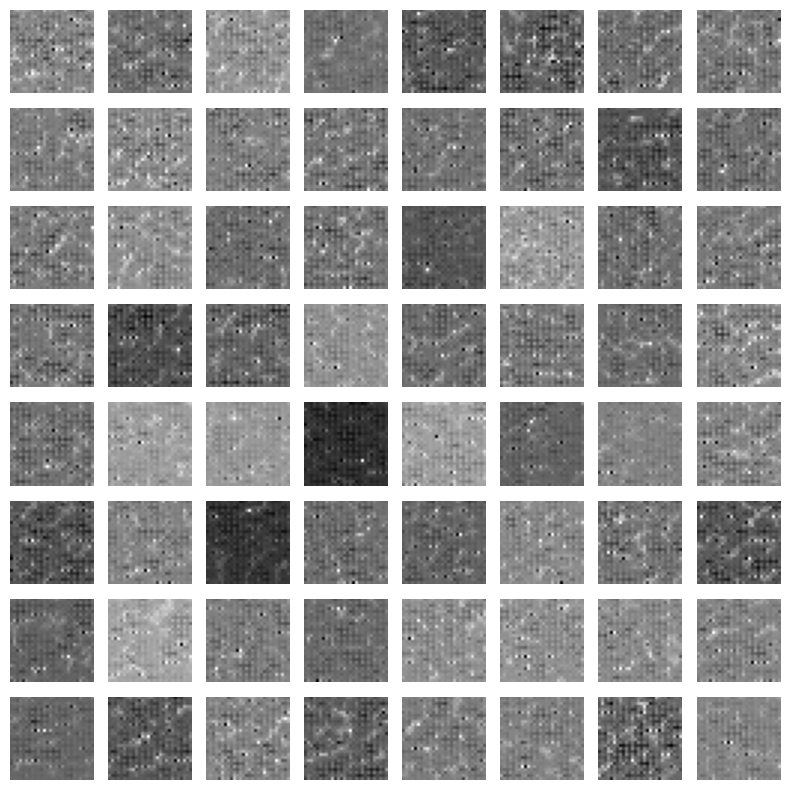

In [ ]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def visualize_samples(flow, n_samples=64):
    flow.eval()

    # Determine latent shape from last saved shape during forward pass
    z_shape = flow.saved_shapes[-1]
    z_dim = torch.tensor(z_shape[1:]).prod().item()

    # Generate a full latent vector matching total expected dimension
    total_latent_dim = sum(
        torch.tensor(shape[1:]).prod().item()
        for shape in flow.saved_shapes
    )
    z = torch.randn(n_samples, total_latent_dim).to(next(flow.parameters()).device)

    # Generate images
    samples = flow.inverse(z).cpu()

    # Plot results
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        ax.imshow(samples[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(flow)

The visualizations are pretty bad due lack of training.

Now we implemented the key structural components of GLOW, a more expressive and better-performing normalizing flow for image generation.



In [ ]:
class ActNorm2d(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        self.initialized = False
        self.bias = nn.Parameter(torch.zeros(1, num_channels, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, num_channels, 1, 1))

    def initialize(self, x):
        with torch.no_grad():
            mean = x.mean(dim=[0, 2, 3], keepdim=True)
            std = x.std(dim=[0, 2, 3], keepdim=True)
            self.bias.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))
            self.initialized = True

    def forward(self, x):
        if not self.initialized:
            self.initialize(x)
        log_abs = self.scale.abs().log()
        log_det = torch.sum(log_abs) * x.size(2) * x.size(3)
        return self.scale * (x + self.bias), log_det

    def inverse(self, x):
        return x / self.scale - self.bias

In [ ]:
class Invertible1x1Conv(nn.Module):
    def __init__(self, num_channels):
        super().__init__()
        w_init = torch.qr(torch.randn(num_channels, num_channels))[0]
        self.weight = nn.Parameter(w_init)

    def forward(self, x):
        B, C, H, W = x.shape
        weight = self.weight.view(C, C, 1, 1)
        log_det = torch.slogdet(self.weight)[1] * H * W
        return F.conv2d(x, weight), log_det

    def inverse(self, x):
        C = x.shape[1]
        inv_weight = self.weight.inverse().view(C, C, 1, 1)
        return F.conv2d(x, inv_weight)

In [ ]:
class GlowCouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels // 2, hidden_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, hidden_channels, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, in_channels, 3, padding=1)
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, 1)
        st = self.net(x_a)
        s, t = st.chunk(2, 1)
        s = torch.tanh(s)
        z_b = x_b * torch.exp(s) + t
        log_det = s.view(s.size(0), -1).sum(dim=1)
        return torch.cat([x_a, z_b], dim=1), log_det

    def inverse(self, z):
        z_a, z_b = z.chunk(2, 1)
        st = self.net(z_a)
        s, t = st.chunk(2, 1)
        s = torch.tanh(s)
        x_b = (z_b - t) * torch.exp(-s)
        return torch.cat([z_a, x_b], dim=1)

In [ ]:
class GlowStep(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.actnorm = ActNorm2d(in_channels)
        self.inv1x1 = Invertible1x1Conv(in_channels)
        self.coupling = GlowCouplingLayer(in_channels, hidden_channels)

    def forward(self, x):
        x, log_det1 = self.actnorm(x)
        x, log_det2 = self.inv1x1(x)
        x, log_det3 = self.coupling(x)
        return x, log_det1 + log_det2 + log_det3

    def inverse(self, z):
        z = self.coupling.inverse(z)
        z = self.inv1x1.inverse(z)
        z = self.actnorm.inverse(z)
        return z

In [ ]:
# --- Glow Block: Stacked Steps + Squeeze + Split ---
class SqueezeLayer(nn.Module):
    def forward(self, x):
        B, C, H, W = x.size()
        if H % 2 != 0 or W % 2 != 0:
            raise ValueError(f"Squeeze requires even spatial dims, got {H}x{W}")
        x = x.view(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        return x.view(B, C * 4, H // 2, W // 2)

    def inverse(self, x):
        B, C, H, W = x.size()
        x = x.view(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        return x.view(B, C // 4, H * 2, W * 2)


class GlowBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, n_steps):
        super().__init__()
        self.squeeze = SqueezeLayer()
        self.steps = nn.ModuleList([
            GlowStep(in_channels * 4, hidden_channels)
            for _ in range(n_steps)
        ])
        self.split = in_channels * 2  # Half of squeezed

    def forward(self, x):
        x = self.squeeze(x)
        log_det_total = 0
        for step in self.steps:
            x, log_det = step(x)
            log_det_total += log_det
        z, x = x[:, :self.split], x[:, self.split:]
        return z, x, log_det_total

    def inverse(self, z, x):
        x = torch.cat([z, x], dim=1)
        for step in reversed(self.steps):
            x = step.inverse(x)
        x = self.squeeze.inverse(x)
        return x


In [ ]:
# --- Full Glow Model ---
class Glow(nn.Module):
    def __init__(self, levels=3, steps_per_level=4, in_channels=1, hidden_channels=128):
        super().__init__()
        self.blocks = nn.ModuleList()
        C = in_channels
        for _ in range(levels):
            block = GlowBlock(C, hidden_channels, steps_per_level)
            self.blocks.append(block)
            C *= 2  # After split

    def forward(self, x):
        log_det_total = 0
        zs = []
        for block in self.blocks:
            z, x, log_det = block(x)
            zs.append(z.view(z.size(0), -1))
            log_det_total += log_det
        zs.append(x.view(x.size(0), -1))
        return torch.cat(zs, dim=1), log_det_total

    def inverse(self, z):
        zs = []
        B = z.size(0)
        split_idx = 0
        shapes = []

        # Rebuild shape sizes
        C, H, W = 1, 28, 28
        for block in self.blocks:
            C *= 4
            H //= 2
            W //= 2
            split = C // 2
            shapes.append((split, C - split, H, W))
            C = C // 2

        # Split z into chunks
        z_chunks = []
        for zc, xc, h, w in shapes:
            size_z = zc * h * w
            z_chunks.append(z[:, split_idx:split_idx + size_z].view(B, zc, h, w))
            split_idx += size_z
        remaining = z[:, split_idx:].view(B, shapes[-1][1], shapes[-1][2], shapes[-1][3])

        # Inverse pass
        x = remaining
        for block, z_chunk in reversed(list(zip(self.blocks, z_chunks))):
            x = block.inverse(z_chunk, x)
        return x

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset: MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Model
glow = Glow(levels=2, steps_per_level=4, in_channels=1, hidden_channels=128).to(device)
optimizer = optim.Adam(glow.parameters(), lr=1e-3)
base_dist = torch.distributions.Normal(0, 1)

# Training
epochs = 20
for epoch in range(epochs):
    glow.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        z, log_det = glow(x)
        log_pz = base_dist.log_prob(z).sum(dim=1)
        loss = -(log_pz + log_det).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/20 - Loss: -2424.0637
Epoch 2/20 - Loss: -3022.0763
Epoch 3/20 - Loss: -3438.8355
Epoch 4/20 - Loss: -3547.0845
Epoch 5/20 - Loss: -3290.9591
Epoch 6/20 - Loss: -3842.3125
Epoch 7/20 - Loss: -3969.0827
Epoch 8/20 - Loss: -3980.4935
Epoch 9/20 - Loss: -4030.9242
Epoch 10/20 - Loss: -4360.5689
Epoch 11/20 - Loss: -3207.6437
Epoch 12/20 - Loss: -3052.1549
Epoch 13/20 - Loss: -3721.0313
Epoch 14/20 - Loss: -4063.5609
Epoch 15/20 - Loss: -4413.2240
Epoch 16/20 - Loss: -4413.8213
Epoch 17/20 - Loss: -4510.6575
Epoch 18/20 - Loss: -4546.6721
Epoch 19/20 - Loss: -4445.2587
Epoch 20/20 - Loss: -4483.9666


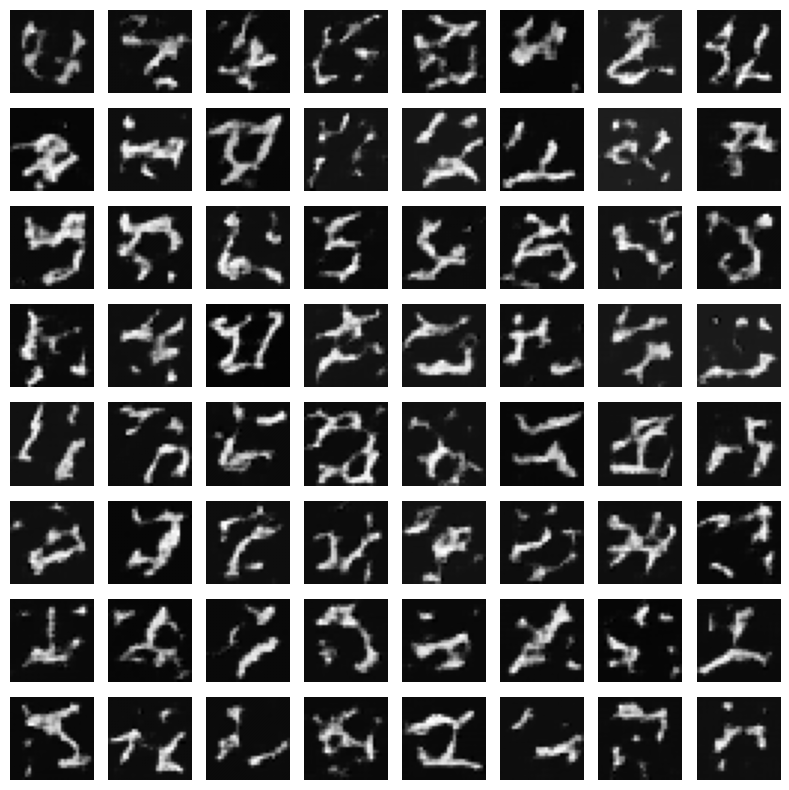

In [ ]:
import matplotlib.pyplot as plt
import torch

@torch.no_grad()
def visualize_glow(glow_model, n_samples=64):
    glow_model.eval()
    device = next(glow_model.parameters()).device

    # Perform a forward pass on dummy input to capture output shape
    dummy_input = torch.randn(1, 1, 28, 28).to(device)
    with torch.no_grad():
        z_dummy, _ = glow_model(dummy_input)
        latent_dim = z_dummy.size(1)

    # Sample from base distribution
    z = torch.randn(n_samples, latent_dim).to(device)

    # Generate images from inverse flow
    generated = glow_model.inverse(z).cpu()

    # Plot 8x8 grid
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        ax.imshow(generated[i].squeeze(), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

visualize_glow(glow)

It still needs more training to perform at a good level.